In [ ]:
!unzip './mitbih_train.csv.zip'

Archive:  ./mitbih_train.csv.zip
  inflating: mitbih_train.csv        
  inflating: __MACOSX/._mitbih_train.csv  


In [ ]:
# -*- coding: utf-8 -*-

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

""" First Dataset Exploration """

# Loading MITBIH data
df_bih1 = pd.read_csv('./mitbih_train.csv', header=None)



df_bih1[187]=df_bih1[187].astype(int)
equilibre=df_bih1[187].value_counts()
print(equilibre)

# Rebalancing Dataset
from sklearn.utils import resample
df_1=df_bih1[df_bih1[187]==1]
df_2=df_bih1[df_bih1[187]==2]
df_3=df_bih1[df_bih1[187]==3]
df_4=df_bih1[df_bih1[187]==4]
df_0=(df_bih1[df_bih1[187]==0]).sample(n=20000,random_state=42)

df_1_upsample=resample(df_1,replace=True,n_samples=20000,random_state=123)
df_2_upsample=resample(df_2,replace=True,n_samples=20000,random_state=124)
df_3_upsample=resample(df_3,replace=True,n_samples=20000,random_state=125)
df_4_upsample=resample(df_4,replace=True,n_samples=20000,random_state=126)

train_df=pd.concat([df_0,df_1_upsample,df_2_upsample,df_3_upsample,df_4_upsample])

# Dataset is rebalanced here
train_df[187].value_counts()


X = train_df.values[:,:-1]
y = train_df.values[:,-1]


0    72471
4     6431
2     5788
1     2223
3      641
Name: 187, dtype: int64


In [ ]:
# -*- coding: utf-8 -*-

from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.layers import Dense, Convolution1D, MaxPool1D, Flatten, Dropout
from keras.layers import Input
from keras.layers import Input, Dense, Conv1D, MaxPooling1D, Softmax, Add, Flatten, Activation
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
from keras.optimizers import Adam


y = to_categorical(y)

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3)

X_train = X_train.reshape(len(X_train), X_train.shape[1],1)
X_test = X_test.reshape(len(X_test), X_test.shape[1],1)

print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)

def conv_net():
    n_obs, feature, depth = X_train.shape
    batch_size = 500

    inp = Input(shape=(feature, depth))
    C = Conv1D(filters=32, kernel_size=5, strides=1)(inp)

    C11 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(C)
    A11 = Activation("relu")(C11)
    C12 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(A11)
    S11 = Add()([C12, C])
    A12 = Activation("relu")(S11)
    M11 = MaxPooling1D(pool_size=5, strides=2)(A12)


    C21 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(M11)
    A21 = Activation("relu")(C21)
    C22 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(A21)
    S21 = Add()([C22, M11])
    A22 = Activation("relu")(S11)
    M21 = MaxPooling1D(pool_size=5, strides=2)(A22)


    C31 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(M21)
    A31 = Activation("relu")(C31)
    C32 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(A31)
    S31 = Add()([C32, M21])
    A32 = Activation("relu")(S31)
    M31 = MaxPooling1D(pool_size=5, strides=2)(A32)


    C41 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(M31)
    A41 = Activation("relu")(C41)
    C42 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(A41)
    S41 = Add()([C42, M31])
    A42 = Activation("relu")(S41)
    M41 = MaxPooling1D(pool_size=5, strides=2)(A42)


    C51 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(M41)
    A51 = Activation("relu")(C51)
    C52 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(A51)
    S51 = Add()([C52, M41])
    A52 = Activation("relu")(S51)
    M51 = MaxPooling1D(pool_size=5, strides=2)(A52)

    F1 = Flatten()(M51)

    D1 = Dense(32)(F1)
    A6 = Activation("relu")(D1)
    D2 = Dense(32)(A6)
    D3 = Dense(5)(D2)
    A7 = Softmax()(D3)
    
    model = Model(inputs=inp, outputs=A7)
    
    def exp_decay(epoch):
        initial_lrate = 0.001
        k = 0.75
        t = n_obs//(10000 * batch_size)  # every epoch we do n_obs/batch_size iteration
        lrate = initial_lrate * math.exp(-k*t)
        return lrate

    lrate = LearningRateScheduler(exp_decay)
    adam = Adam(lr = 0.001, beta_1 = 0.9, beta_2 = 0.999)


    model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
    return model

Using TensorFlow backend.


NameError: ignored

In [ ]:
model = conv_net()

callbacks = [EarlyStopping(monitor='val_loss', patience=8)]
history=model.fit(X_train, y_train,epochs=40,callbacks=callbacks, batch_size=32,validation_data=(X_test,y_test))


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 70000 samples, validate on 30000 samples
Epoch 1/40





70000/70000 [==============================] - 93s 1ms/step - loss: 0.3337 - acc: 0.8780 - val_loss: 0.1953 - val_acc: 0.9324
Epoch 2/40
70000/70000 [==============================] - 92s 1ms/step - loss: 0.1468 - acc: 0.9479 - val_loss: 0.1737 - val_acc: 0.9406
Epoch 3/40
70000/70000 [==============================] - 92s 1ms/step - loss: 0.1053 - acc: 0.9628 - val_loss: 0.1002 - val_acc: 0.9647
Epoch 4/40
70000/70000 [==============================] - 91s 1ms/step - loss: 0.0887 - acc: 0.9699 - val_loss: 0.0842 - val_acc: 0.9724
Epoch 5/40
70000/70000 [==============================] - 91s 1ms/step - loss: 0.0728 - acc: 0.9752 - val_loss: 0.0832 - val_acc: 0.9723
Epoch 6/40
70000/70000 [==============================] - 91s 1ms/step - loss: 0.0674 - acc: 0.9779 - val_loss: 0.0721 - val_acc: 0.9770
Epoch 7/40
70000/70000 [==

In [ ]:
history.history.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

In [ ]:
model.save('model.h5')


Accuracy: 98.11%


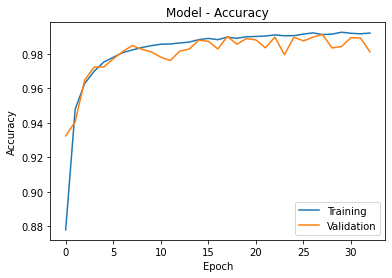

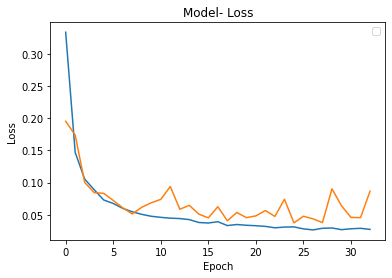

In [ ]:
from sklearn.metrics import confusion_matrix
def evaluate_model(history,X_test,y_test,model):
    scores = model.evaluate((X_test),y_test, verbose=0)
    print("Accuracy: %.2f%%" % (scores[1]*100))
    
    print(history)
    fig1, ax_acc = plt.subplots()
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Model - Accuracy')
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()
    
    fig2, ax_loss = plt.subplots()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Model- Loss')
    plt.legend(['Training', 'Validation'], loc='upper right')
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.show()
    target_names=['0','1','2','3','4']
    
    y_true=[]
    for element in y_test:
        y_true.append(np.argmax(element))
    prediction_proba=model.predict(X_test)
    prediction=np.argmax(prediction_proba,axis=1)
    cnf_matrix = confusion_matrix(y_true, prediction)
    
evaluate_model(history,X_test,y_test,model)



              precision    recall  f1-score   support

           0       0.97      0.95      0.96      5946
           1       0.98      0.98      0.98      5848
           2       0.97      0.99      0.98      6148
           3       0.99      0.99      0.99      6011
           4       0.99      1.00      0.99      6047

    accuracy                           0.98     30000
   macro avg       0.98      0.98      0.98     30000
weighted avg       0.98      0.98      0.98     30000

Confusion matrix, without normalization


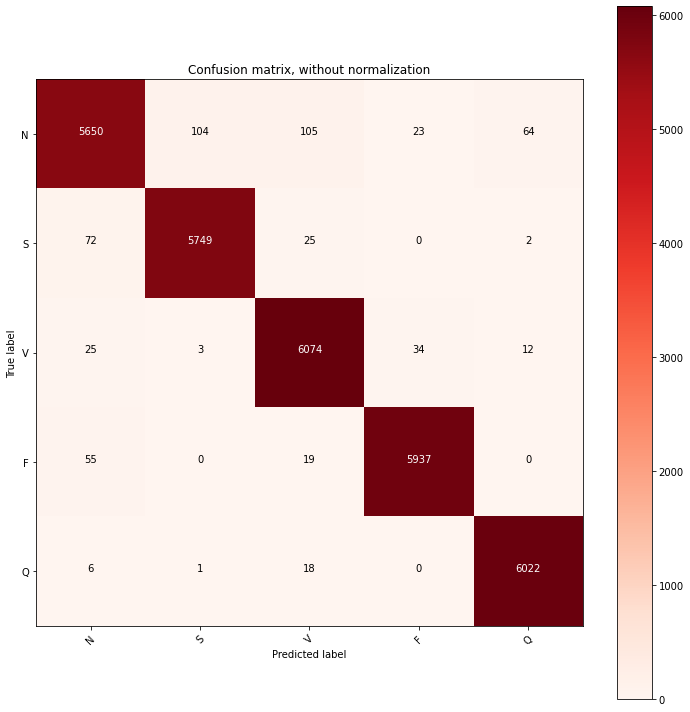

In [ ]:
y_pred = model.predict(X_test, batch_size=1000)
from sklearn.metrics import classification_report
import itertools

print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)))

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Reds):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(10, 10))
plot_confusion_matrix(cnf_matrix, classes=['N', 'S', 'V', 'F', 'Q'],
                      title='Confusion matrix, without normalization')
plt.show()
